<a href="https://colab.research.google.com/github/shimo23333/generative_ai/blob/main/AI%E6%9C%9F%E6%9C%AB_0603%E8%B7%A8%E6%96%87%E5%8C%96%E8%89%B2%E5%BD%A9%E8%AA%9E%E6%84%8F%E6%AF%94%E8%BC%83_CLIP%E4%B8%AD%E8%AA%9E%E8%A8%80%E5%B0%8D%E8%89%B2%E5%BD%A9%E7%90%86%E8%A7%A3%E7%9A%84%E5%B7%AE%E7%95%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1:安裝
!pip install -q git+https://github.com/openai/CLIP.git #從GitHub安裝OpenAI的CLIP
!pip install -q scikit-image #處理影像
!pip install -q opencv-python #影像處理工具(OpenCV)
!pip install -q diffusers transformers accelerate invisible-watermark safetensors #為了使用StableDiffusion
!pip install -q ipywidgets
!pip install -q sentencepiece sacremoses #翻譯模型
!apt-get -y install fonts-noto-cjk #嘗試

  Preparing metadata (setup.py) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
#2:匯入
import torch
import clip #轉成向量
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans #用來找圖片裡最主要的幾個顏色
from skimage.color import rgb2lab #把圖片從 RGB 顏色轉成 LAB 顏色空間的工具
import cv2
from diffusers import StableDiffusionPipeline #tableDiffusion
import os
from sklearn.metrics.pairwise import cosine_similarity #比文字與圖像的語意是不是接近?
from tqdm.notebook import tqdm
import time
import matplotlib.font_manager as fm
from transformers import pipeline as hf_pipeline
import re #生成concept_name

print("2:函式庫匯入完成。")

2:函式庫匯入完成。


In [ ]:
#這是一個用來設定「整個專案環境」的類別，自動檢查是不是能用GPU、設定好畫圖用的中文字體，同時確保圖像要存的資料夾已經建立好。
#原本是ai生成的但已經過我的理解與整理
class ConfigManager:
    def __init__(self, font_path_cjk='/usr/share/fonts/opentype/noto/NotoSansCJKjp-Regular.otf',
                 images_out_dir="project_outputs_final_v4_oop_hf"):
        self.device = self._get_device()
        self.font_path_cjk = font_path_cjk
        self.images_out_dir = images_out_dir
        self._setup_matplotlib_font()
        self._setup_output_directory()
        self.hf_device_id = 0 if self.device == "cuda" else -1

    def _get_device(self):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"4:本次運行的計算設備是: {device}")
        if device == "cpu":
            print("警告：未使用GPU！運行大型AI模型會非常慢。")
        return device

    def _setup_matplotlib_font(self):
        print("3:正在設定 Matplotlib CJK 字體...")
        if os.path.exists(self.font_path_cjk):
            try:
                fm.fontManager.addfont(self.font_path_cjk)
                prop = fm.FontProperties(fname=self.font_path_cjk)
                font_name = prop.get_name()
                plt.rcParams['font.family'] = font_name
                plt.rcParams['axes.unicode_minus'] = False
                print(f"  已成功設定 CJK 字體為: {font_name}")
            except Exception as e:
                print(f"  設定字體 '{self.font_path_cjk}' 時發生錯誤: {e}. 退到通用列表。")
                plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'SimHei', 'DejaVu Sans', 'sans-serif']
        else:
            print(f"  指定的 CJK 字體文件路徑不存在: {self.font_path_cjk}. 退到通用列表。")
            plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'SimHei', 'DejaVu Sans', 'sans-serif']
        plt.rcParams['axes.unicode_minus'] = False
        print("3:Matplotlib CJK 字體設定完畢。")

    def _setup_output_directory(self):
        if not os.path.exists(self.images_out_dir):
            os.makedirs(self.images_out_dir)
            print(f"  已建立圖像儲存目錄: {self.images_out_dir}")

In [ ]:
#這個類別是用來處理「各種模型的載入與管理」的，幫我把三種重要的模型準備好，CLIP、Stable Diffusion、翻譯模型
#原本是ai生成的但已經過我的理解與整理，並且也自己找了應該可行的模型

class ModelManager:
    def __init__(self, device, hf_device_id):
        self.device = device
        self.hf_device_id = hf_device_id
        self.clip_model = None
        self.clip_preprocess = None
        self.sd_pipeline = None
        self.translation_pipelines = {}

    def load_clip_model(self, model_name="ViT-B/32"):
        print(f"5:準備載入 CLIP 模型 ({model_name})...")
        if self.device == "cuda":
            try:
                self.clip_model, self.clip_preprocess = clip.load(model_name, device=self.device)
                self.clip_model.eval()
                print(f"  CLIP 模型 ({model_name}) 已成功載入到 {self.device}！")
                torch.cuda.empty_cache()
            except Exception as e:
                print(f"  載入CLIP模型時發生錯誤: {e}")
                self.clip_model, self.clip_preprocess = None, None
        else:
            print(f"  未實際載入CLIP模型，因為當前運算設備是 {self.device}。")
        return self.clip_model, self.clip_preprocess

    def load_sd_model(self, model_id="runwayml/stable-diffusion-v1-5"):
        print(f"6:準備載入 Stable Diffusion 模型 ({model_id})...")
        if self.device == "cuda":
            try:
                self.sd_pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
                self.sd_pipeline = self.sd_pipeline.to(self.device)
                print(f"  Stable Diffusion 模型 ({model_id}) 已成功載入到 {self.device}！")
                torch.cuda.empty_cache()
            except Exception as e:
                print(f"  載入Stable Diffusion模型時發生錯誤: {e}")
                self.sd_pipeline = None
        else:
            print(f"  未實際載入Stable Diffusion模型，因為當前運算設備是 {self.device}。")
        return self.sd_pipeline

    def init_translation_models(self, target_languages=['en', 'ja', 'ko']):
        print("7:正在初始化 Hugging Face 翻譯模型...")
        model_map = {
            'en': 'Helsinki-NLP/opus-mt-zh-en',
            'ja': 'Helsinki-NLP/opus-mt-tc-big-zh-ja', # 網路上自己找到的模型
            'ko': 'Helsinki-NLP/opus-mt-tc-big-zh-ja'  # 網路上自己找到的模型
        }
        loaded_any_model = False
        for lang_code in target_languages:
            if lang_code in model_map:
                model_name = model_map[lang_code]
                try:
                    print(f"  載入翻譯模型 for zh -> {lang_code} ({model_name})...")
                    translator = hf_pipeline(f"translation_zh_to_{lang_code}", # 任務名可能需要調整
                                          model=model_name,
                                          device=self.hf_device_id)
                    self.translation_pipelines[lang_code] = translator
                    print(f"    翻譯模型 for zh -> {lang_code} ({model_name}) 載入成功。")
                    loaded_any_model = True
                except Exception as e:
                    print(f"    載入翻譯模型 for zh -> {lang_code} ({model_name}) 失敗: {e}")
                    self.translation_pipelines[lang_code] = None
            else:
                print(f"  未找到針對 zh -> {lang_code} 的預定義翻譯模型。")
        if not loaded_any_model:
            print("警告: 未能成功載入任何Hugging Face翻譯模型。自動翻譯功能將受限。")
        return self.translation_pipelines

    def cleanup(self):
        print("正在清理模型資源...")
        if self.clip_model: del self.clip_model
        if self.clip_preprocess: del self.clip_preprocess
        if self.sd_pipeline: del self.sd_pipeline
        if self.translation_pipelines:
            for lang, pipe in self.translation_pipelines.items():
                if pipe: del pipe
            self.translation_pipelines.clear()
            if self.device == "cuda":
                torch.cuda.empty_cache()
        if self.device == "cuda":
            torch.cuda.empty_cache()
        print("  模型和資源清理操作已執行。")

In [ ]:
#用來處理:詞彙概念的建立與管理，"希望能"幫我把一個「中文概念」翻譯成多種語言版本（中、英、日、韓）
#並且記錄每個單字、原始中文、和各語言的詞彙說明(這部分一直做不太成功)
#總之就是自動翻譯，也請ai幫我做過好幾版，結果都不太好，又經過好幾次自己手動改跟摸索......

class ConceptDataProvider:
    def __init__(self, clear_default_concepts=False): # 新增參數
        self.word_concepts_list = [] # 默認清空，由用戶在main中添加
        if not clear_default_concepts:
            # 如果需要，可以保留原有的預設列表
            self.word_concepts_list = [
                {"concept_name": "cool_ambiguous", "base_chinese": "酷 / 涼爽", "translations": {"zh": "冰涼的飲料，酷炫的風格，冷靜的態度", "en": "cool refreshing drink, cool stylish look, calm and cool attitude", "ja": "冷たい飲み物、かっこいいスタイル、冷静な態度", "ko": "시원한 음료, 멋진 스타일, 침착한 태도"}},

            ]
        self.word_concepts_to_process = self.word_concepts_list
        print(f"8:初始定義了 {len(self.word_concepts_list)} 個詞彙概念。")

    def _generate_concept_name(self, base_chinese):
        """根據中文詞彙生成一個簡化的英文概念名"""
        name = re.sub(r'[^\w]', '', base_chinese) #移除非字母數字字符(測試中總是亂碼)
        name = name[:20] #限制長度
        if not name: name = "unnamed_concept"
        return f"{name}_auto_translated"

    #自動呼叫翻譯模型，核心功能~~~
    def add_concept_with_auto_translation(self, translation_pipelines, base_chinese,
                                          chinese_description_for_prompt=None, target_languages=['en', 'ja', 'ko']):
        """
        新增一個概念，並使用 Hugging Face pipeline 自動翻譯其描述性句子。
        如果 chinese_description_for_prompt 未提供，則直接翻譯 base_chinese。
        """
        concept_name = self._generate_concept_name(base_chinese)
        text_to_translate = chinese_description_for_prompt if chinese_description_for_prompt else base_chinese

        print(f"\n  準備新增概念 '{concept_name}' (基於 '{base_chinese}')...")
        print(f"    將翻譯: '{text_to_translate[:50]}...'")

        if not translation_pipelines or not any(translation_pipelines.values()):
            print("    錯誤：翻譯 pipelines 未提供或均未成功載入，無法自動翻譯。將使用原文作為提示。")
            translations = {lang: text_to_translate for lang in target_languages}
            translations['zh'] = text_to_translate
        else:
            translations = {"zh": text_to_translate}
            for lang_code in target_languages:
                translator_pipeline = translation_pipelines.get(lang_code)
                if translator_pipeline:
                    try:
                        translated_result = translator_pipeline(text_to_translate)
                        translated_text = translated_result[0]['translation_text']
                        translations[lang_code] = translated_text
                        print(f"      -> {lang_code.upper()}: {translated_text}")
                    except Exception as e:
                        print(f"      使用Hugging Face模型翻譯到 {lang_code.upper()} 失敗: {e}")

                        #原本的AI生成
                        # translations[lang_code] = f"翻譯失敗: {text_to_translate}"
                        #更改
                        translations[lang_code] = text_to_translate
                #原本的AI生成
                # else:
                #     print(f"      未找到 {lang_code.upper()} 的翻譯 pipeline，使用原文。")
                #     translations[lang_code] = text_to_translate
                #更改
                else:
                      print(f"未找到{lang_code.upper()}的翻譯pipeline，該語言將跳過。")
                #不加入translations，後面自動對不存在語言略過

        new_concept = {
            "concept_name": concept_name,
            "base_chinese": base_chinese,
            "translations": translations
        }
        self.word_concepts_list.append(new_concept)
        print(f"  新概念 '{concept_name}' 已成功添加。現有 {len(self.word_concepts_list)} 個概念。")
        print(f"8(更新):定義了 {len(self.word_concepts_to_process)} 個詞彙概念用於本次分析。")

    def get_concepts_to_process(self):
        if not self.word_concepts_to_process:
            print("警告：沒有定義任何詞彙概念進行處理。")
        return self.word_concepts_to_process

In [ ]:
#主要處理CLIP的文本分析功能
#作用1.把多語言的提示詞送進CLIP模型，轉換成向量
#作用2.比較不同語言之間的語意相似度
#希望能以此判斷「翻譯後的提示詞」在語意上是不是相近
#這段原本也是ai生成的，經過我的理解與整理:

class TextAnalyzer:
    def __init__(self, clip_model, device):
        self.clip_model = clip_model
        self.device = device
    def get_clip_text_embeddings(self, text_prompts_dict):
        if self.clip_model is None:
            print("  警告: CLIP 模型未載入，文本嵌入將為零向量。")
            return {lang_code: np.zeros(512, dtype=np.float32) for lang_code in text_prompts_dict}
        text_embeddings_result_dict = {}
        with torch.no_grad():
            for lang_tag, text_content in text_prompts_dict.items():
                try:
                    tokenized_input_text = clip.tokenize([text_content]).to(self.device)
                    text_semantic_features = self.clip_model.encode_text(tokenized_input_text)
                    text_semantic_features /= text_semantic_features.norm(dim=-1, keepdim=True)
                    text_embeddings_result_dict[lang_tag] = text_semantic_features.cpu().numpy().flatten()
                except Exception as e:
                    print(f"為 '{lang_tag}':'{text_content[:30]}...' 生成CLIP嵌入時出錯: {e}")
                    text_embeddings_result_dict[lang_tag] = np.zeros(512, dtype=np.float32)
        return text_embeddings_result_dict
    def calculate_embedding_similarity(self, embeddings_dict, reference_lang='en'):
        similarity_scores_result = {}
        if reference_lang not in embeddings_dict or embeddings_dict.get(reference_lang) is None or np.all(np.isclose(embeddings_dict[reference_lang], 0)):
            print(f"  參考語言 '{reference_lang.upper()}' 的嵌入向量無效或不存在，無法計算相似度。")
            return {f"{reference_lang}_vs_{lang}": None for lang in embeddings_dict if lang != reference_lang}
        print(f"  CLIP文本嵌入向量餘弦相似度 (vs '{reference_lang.upper()}'):")
        ref_embedding = embeddings_dict[reference_lang].reshape(1, -1)
        for lang, emb in embeddings_dict.items():
            if lang == reference_lang: continue
            sim_val_str = "N/A (嵌入無效)"
            sim_num = None
            if emb is not None and not np.all(np.isclose(emb, 0)):
                sim_num = cosine_similarity(ref_embedding, emb.reshape(1, -1))[0][0]
                sim_val_str = f"{sim_num:.3f}"
            similarity_scores_result[f"{reference_lang}_vs_{lang}"] = sim_num
            print(f"    - 與 {lang.upper()}: {sim_val_str}")
        return similarity_scores_result

In [ ]:
#處理「圖像生成與分析」的功能
#作用1.用Stable Diffusion模型根據提示詞生成圖片(目前成效不佳)
#作用2.圖片中提取出主色
#作用3.分析圖片的整體亮度、對比、飽和度

class ImageProcessor:
    def __init__(self, sd_pipeline, device):
        self.sd_pipeline = sd_pipeline
        self.device = device

    #測試
    def generate_image_from_prompt(self, prompt):
        image = self.sd_pipeline(prompt).images[0]
        return image


    def generate_image_with_sd(self, prompt_text, random_seed=42, inference_steps=30, cfg_scale=7.5):
        if self.sd_pipeline is None:
            placeholder_img = Image.new('RGB', (512, 512), color='silver')
            draw = ImageDraw.Draw(placeholder_img)
            try: font = ImageFont.truetype("DejaVuSans.ttf", 18)
            except IOError: font = ImageFont.load_default()
            draw.text((10, 10), f"SD模型未載入\n提示:\n{prompt_text[:70]}...", fill=(60, 60, 60), font=font)
            return placeholder_img
        try:
            gen = torch.Generator(device=self.device).manual_seed(random_seed)
            with torch.no_grad():
                img = self.sd_pipeline(prompt_text, num_inference_steps=inference_steps, guidance_scale=cfg_scale, generator=gen).images[0]
            return img
        except Exception as e:
            print(f"  生成圖像時出錯 ('{prompt_text[:40]}...'): {e}")
            error_img = Image.new('RGB', (512, 512), color='lightcoral')
            draw = ImageDraw.Draw(error_img)
            try: font = ImageFont.truetype("DejaVuSans.ttf", 15)
            except IOError: font = ImageFont.load_default()
            draw.text((10, 10), f"圖像生成錯誤:\n{prompt_text[:60]}...\n錯誤:\n{str(e)[:100]}", fill=(0, 0, 0), font=font)
            return error_img
    def extract_dominant_colors(self, pil_img, num_colors=5):

        #原本的AI生成
        # if pil_img is None or (hasattr(pil_img, 'width') and pil_img.width < num_colors) or \
        #    (hasattr(pil_img, 'height') and pil_img.height < num_colors):

        #更改
        if pil_img is None or pil_img.width * pil_img.height < num_colors * 4:
             rgb_fallback = np.array([[128, 128, 128]] * num_colors, dtype=int)

             rgb_fallback = np.array([[128, 128, 128]] * num_colors, dtype=int)
             lab_fallback = rgb2lab(rgb_fallback.reshape((num_colors, 1, 3)) / 255.0).reshape((num_colors, 3))
             return rgb_fallback, lab_fallback
        try:
            img_rgb = pil_img.convert('RGB')
            max_dim = 150
            ratio = max_dim / max(img_rgb.width, img_rgb.height)
            new_size = (max(1, int(img_rgb.width * ratio)), max(1, int(img_rgb.height * ratio)))
            img_res = img_rgb.resize(new_size, Image.Resampling.LANCZOS)
            pixels = np.array(img_res).reshape(-1, 3)
            if pixels.shape[0] < num_colors:
                rgb_colors = np.zeros((num_colors, 3), dtype=int)
                actual_extracted_colors = pixels.astype(int)
                rgb_colors[:actual_extracted_colors.shape[0]] = actual_extracted_colors
                if actual_extracted_colors.shape[0] < num_colors:
                    rgb_colors[actual_extracted_colors.shape[0]:] = np.array([128,128,128])
            else:
                kmeans = KMeans(n_clusters=num_colors, random_state=0, n_init='auto', max_iter=200).fit(pixels)
                rgb_colors = kmeans.cluster_centers_.astype(int)
            if rgb_colors.shape[0] < num_colors:
                padded_colors = np.full((num_colors, 3), 128, dtype=int)
                padded_colors[:rgb_colors.shape[0]] = rgb_colors
                rgb_colors = padded_colors
            lab_colors = rgb2lab(rgb_colors.reshape((num_colors, 1, 3)) / 255.0).reshape((num_colors, 3))
            return rgb_colors, lab_colors
        except Exception as e:
            print(f"  提取主色調時出錯: {e}")
            rgb_err = np.array([[100, 100, 100]] * num_colors, dtype=int)
            lab_err = rgb2lab(rgb_err.reshape((num_colors,1,3)) / 255.0).reshape((num_colors, 3))
            return rgb_err, lab_err
    def analyze_global_features(self, pil_image):
        if pil_image is None: return {"avg_brightness": "N/A", "contrast_std": "N/A", "avg_saturation": "N/A"}
        try:
            cv_bgr = np.array(pil_image.convert('RGB'))[:, :, ::-1].copy()
            gray = cv2.cvtColor(cv_bgr, cv2.COLOR_BGR2GRAY)
            brightness = round(np.mean(gray), 2)
            contrast = round(np.std(gray), 2)
            hsv = cv2.cvtColor(cv_bgr, cv2.COLOR_BGR2HSV)
            saturation = round(np.mean(hsv[:, :, 1]), 2)
            return {"avg_brightness": brightness, "contrast_std": contrast, "avg_saturation": saturation}
        except Exception as e:
            print(f"  分析全局圖像特徵時出錯: {e}")
            return {"avg_brightness": "Err", "contrast_std": "Err", "avg_saturation": "Err"}

In [ ]:
#分析報告
#作用1.根據概念和分析結果，產出文字說明框架
#作用2.把圖片、顏色、CLIP相似度、特徵等等畫成一張完整比較圖
#以上就是文字理解~圖像生成~結果分析~報告輸出

class ReportGenerator:
    def generate_explanation_template(self, chinese_concept, lang_prompt_info, dom_colors_hex=None, global_feats=None):
        expl = f"\n--- 解釋模板 for 概念:【{chinese_concept}】| 語言提示: 【{lang_prompt_info[:70]}...】 ---\n"
        if dom_colors_hex: expl += f"圖像主要色票 (HEX): {', '.join(dom_colors_hex[:3])} ...\n"
        if global_feats:
            expl += f"全局圖像特徵: 亮度={global_feats.get('avg_brightness', 'N/A')}, "
            expl += f"對比度={global_feats.get('contrast_std', 'N/A')}, 飽和度={global_feats.get('avg_saturation', 'N/A')}\n"
        expl += f"\n原因推測與圖像描述 (請您填充)：\n"
        expl += f"   [請結合以上客觀指標和您的觀察，詳細闡述：\n"
        expl += f"    a. 圖像視覺風格與氛圍？\n    b. 主要元素與提示詞的關聯？\n    c. 色彩運用如何詮釋提示詞？\n"
        expl += f"    d. (特定語言)文化背景的可能影響？\n    e. 與其他語言生成圖像的差異及可能原因？]\n"
        expl += f"--------------------------------------------------------------------------\n"
        return expl
    def plot_concept_results(self, concept_id, base_chinese, prompts_dict, images_dict,colors_dict, similarities_dict, global_features_dict=None):
        langs = list(prompts_dict.keys())
        num_langs = len(langs)
        if num_langs == 0:
            print(f"概念 '{concept_id}' 無 prompts 可繪製。")
            return
        h_ratio, w_ratio = 2.8, 4.0
        total_h, total_w = h_ratio * 2, w_ratio * num_langs if num_langs > 0 else w_ratio
        fig, axs = plt.subplots(2, max(1, num_langs), figsize=(total_w, total_h), gridspec_kw={'height_ratios': [0.78, 0.22]})
        if num_langs == 1: axs = axs.reshape(2, 1)

        title_base = f"概念分析: '{base_chinese}' ({concept_id})\nCLIP相似度(vs EN): "
        sim_strs = []
        if similarities_dict:
            sim_strs = [f"{k.split('_vs_')[-1].upper()}: {v:.2f}" if isinstance(v, (float, np.floating)) else f"{k.split('_vs_')[-1].upper()}: {v}"
                        for k, v in similarities_dict.items()]
        fig.suptitle(title_base + ", ".join(sim_strs), fontsize=11, y=1.04)
        for i, lang in enumerate(langs):
            img = images_dict.get(lang)
            colors_data = colors_dict.get(lang)
            global_feats_this_lang = (global_features_dict or {}).get(lang, {})
            ax_img = axs[0, i]; ax_color = axs[1, i]
            if img: ax_img.imshow(img)
            else: ax_img.text(0.5, 0.5, '圖像未生成', ha='center', va='center', transform=ax_img.transAxes)
            img_title_prompt = prompts_dict.get(lang, "N/A")
            img_title = f"{lang.upper()}: \"{img_title_prompt[:30]}\"..."
            if global_feats_this_lang:
                img_title += f"\n亮:{global_feats_this_lang.get('avg_brightness', '-')} 對比:{global_feats_this_lang.get('contrast_std', '-')} 飽:{global_feats_this_lang.get('avg_saturation', '-')}"
            ax_img.set_title(img_title, fontsize=7.5); ax_img.axis('off')
            if colors_data is not None:
                rgb_patch, lab_patch = colors_data
                if rgb_patch is not None and len(rgb_patch) > 0 :
                    n_patch = len(rgb_patch)
                    patch_canvas = np.zeros((25, 100, 3), dtype=np.uint8)
                    patch_w = 100 // n_patch
                    for j, rgb_c in enumerate(rgb_patch): patch_canvas[:, j * patch_w:(j + 1) * patch_w] = rgb_c
                    ax_color.imshow(patch_canvas)
                    lab_str_parts = []
                    if lab_patch is not None:
                        for l_val, a_val, b_val in lab_patch[:min(3,n_patch)]: lab_str_parts.append(f"L{l_val:.0f} a{a_val:.0f} b{b_val:.0f}")
                        lab_str = "\n".join(lab_str_parts)
                        ax_color.set_title(f"Lab(Top{min(3,n_patch)}):\n{lab_str}", fontsize=6)
                    else: ax_color.set_title(f"RGB顏色", fontsize=6)
                else: ax_color.text(0.5,0.5,'無顏色數據',ha='center',va='center',transform=ax_color.transAxes, fontsize=6)
            else: ax_color.text(0.5, 0.5, '無顏色', ha='center', va='center', transform=ax_color.transAxes, fontsize=6)
            ax_color.axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()

In [ ]:
#串接所有模組(文字分析+圖像處理+報告生成)
#除錯誤加了if prompt is None:#遇到翻譯缺失就跳

class AnalysisPipeline:
    def __init__(self, config_manager, model_manager, concept_provider, text_analyzer, image_processor, report_generator):
        self.config = config_manager
        self.models = model_manager
        self.concepts_provider = concept_provider
        self.text_analyzer = text_analyzer
        self.image_processor = image_processor
        self.reporter = report_generator
        self.base_seed = 20240101
        self.sd_steps = 20
        self.sd_cfg = 7.0  # 減少步數以加速
        self.num_dom_colors = 5
        self.save_images_flag = True

    def run_analysis(self):
        print(f"Cell 15: 即將開始執行主流程...")
        concepts_to_process = self.concepts_provider.get_concepts_to_process()
        if not concepts_to_process:
            print("沒有概念需要處理，流程結束。")
            return []
        print(f"  將處理 {len(concepts_to_process)} 個詞彙概念...")
        results_collection = []
        for concept_idx, concept_detail in enumerate(tqdm(concepts_to_process, desc="總體概念處理")):
            concept_id = concept_detail["concept_name"]
            base_zh = concept_detail["base_chinese"]
            prompts = concept_detail["translations"]
            print(f"\n\n處理概念 #{concept_idx + 1}: '{base_zh}' ({concept_id})")
            print("  [1. CLIP嵌入分析]")
            embeddings = self.text_analyzer.get_clip_text_embeddings(prompts)
            similarities = self.text_analyzer.calculate_embedding_similarity(embeddings, reference_lang='en')
            print("  [2. 圖像生成、顏色與全局特徵分析]")
            concept_images = {}
            concept_colors = {}
            concept_global_features = {}
            concept_explanations_str = ""

            for lang_idx, (lang, prompt) in enumerate(tqdm(prompts.items(), desc=f"  '{concept_id}'語言處理", leave=False)):
                if not prompt or not prompt.strip():  # 遇到翻譯缺失或空白就跳過
                    print(f"    -> {lang.upper()}: ⚠️ 翻譯缺失或空白，跳過。")
                    continue

                print(f"    -> {lang.upper()}: '{prompt}'")
                img_seed = self.base_seed + concept_idx * 100 + lang_idx * 10

                pil_img = self.image_processor.generate_image_with_sd(
                    prompt,
                    random_seed=img_seed,
                    inference_steps=self.sd_steps,
                    cfg_scale=self.sd_cfg
                )
                concept_images[lang] = pil_img

                if self.save_images_flag and pil_img:
                    try:
                        fname = f"{concept_id}_{lang}_s{img_seed}.png"
                        fpath = os.path.join(self.config.images_out_dir, fname)
                        pil_img.save(fpath)
                    except Exception as e:
                        print(f"      儲存圖像'{fname}'失敗: {e}")

                rgb_cs, lab_cs = self.image_processor.extract_dominant_colors(pil_img, self.num_dom_colors)
                concept_colors[lang] = (rgb_cs, lab_cs)

                global_feats = self.image_processor.analyze_global_features(pil_img)
                concept_global_features[lang] = global_feats

                hex_colors = (
                  [f"#{c[0]:02x}{c[1]:02x}{c[2]:02x}" for c in rgb_cs]
                  if rgb_cs is not None and rgb_cs.size > 0
                  else []
                )

                expl_text = self.reporter.generate_explanation_template(
                    base_zh,
                    f"{lang.upper()}: {prompt}",
                    hex_colors,
                    global_feats
                )
                print(expl_text)
                concept_explanations_str += expl_text

                if self.config.device == "cuda":
                    torch.cuda.empty_cache()
                    time.sleep(0.05)

            print("\n  [3. 繪製結果圖表]")
            self.reporter.plot_concept_results(
                concept_id,
                base_zh,
                prompts,
                concept_images,
                concept_colors,
                similarities,
                concept_global_features
            )
            results_collection.append({
                "concept": concept_id,
                "base_chinese": base_zh,
                "prompts": prompts,
                "similarities": similarities,
                "global_features": concept_global_features,
                "explanation_prompts_combined": concept_explanations_str
            })
            print(f"  概念 '{concept_id}' 分析完畢。")

            if self.config.device == "cuda":
                torch.cuda.empty_cache()

        print("\n\n所有詞彙概念處理完成！解釋模板已在上方打印。")
        return results_collection


In [ ]:
#5.執行分析流程或跳過
concept_provider = ConceptDataProvider(clear_default_concepts=True)
text_analyzer = TextAnalyzer(clip_model=clip_model, device=config_mgr.device)
image_processor = ImageProcessor(sd_pipeline=sd_pipeline, device=config_mgr.device)
report_generator = ReportGenerator()

if not concept_provider.get_concepts_to_process():
    print("沒有任何概念被定義，無法執行分析流程。請檢查 `chinese_terms_to_analyze`。")
else:
    # 使用修正後的分析流程（避免 numpy 陣列布林判斷錯誤）
    def safe_run_analysis():
        results = []
        concepts = concept_provider.get_concepts_to_process()

        for concept in concepts:
            print(f"\n🔍 分析概念: {concept['base_chinese']} ({concept['translations']})")
            concept_global_features = {}

            # 從 translations 生成提示詞
            prompts = {}
            for lang, translated_desc in concept['translations'].items():
                prompts[lang] = translated_desc  # 假設 translation 文字本身就是提示用語句

            for lang, prompt in prompts.items():
                print(f"  ➤ 處理語言: {lang} | 提示詞: {prompt}")

                # 1. 產生圖片
                image = image_processor.generate_image_from_prompt(prompt)

                # 2. 分析圖像特徵
                global_feats, rgb_cs = text_analyzer.extract_features_and_colors(image)
                concept_global_features[lang] = global_feats

                if rgb_cs is not None and len(rgb_cs) > 0:
                    hex_colors = [f"#{c[0]:02x}{c[1]:02x}{c[2]:02x}" for c in rgb_cs]
                else:
                    hex_colors = []

                # 3. 生成解釋文字
                expl_text = report_generator.generate_explanation_template(
                    base_chinese=concept['base_chinese'],
                    prompt_lang=lang,
                    prompt_text=prompt,
                    hex_colors=hex_colors
                )

                # 4. 彙總結果
                result_entry = {
                    'concept': concept['base_chinese'],
                    'language': lang,
                    'prompt': prompt,
                    'colors': hex_colors,
                    'features': global_feats,
                    'explanation': expl_text,
                    'image': image
                }

                results.append(result_entry)

        return results

    all_results = safe_run_analysis()


8:初始定義了 0 個詞彙概念。
警告：沒有定義任何詞彙概念進行處理。
沒有任何概念被定義，無法執行分析流程。請檢查 `chinese_terms_to_analyze`。


4:本次運行的計算設備是: cuda
3:正在設定 Matplotlib CJK 字體...
  指定的 CJK 字體文件路徑不存在: /usr/share/fonts/opentype/noto/NotoSansCJKjp-Regular.otf. 退到通用列表。
3:Matplotlib CJK 字體設定完畢。
5:準備載入 CLIP 模型 (ViT-B/32)...
  CLIP 模型 (ViT-B/32) 已成功載入到 cuda！
6:準備載入 Stable Diffusion 模型 (runwayml/stable-diffusion-v1-5)...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  Stable Diffusion 模型 (runwayml/stable-diffusion-v1-5) 已成功載入到 cuda！
7:正在初始化 Hugging Face 翻譯模型...
  載入翻譯模型 for zh -> en (Helsinki-NLP/opus-mt-zh-en)...


Device set to use cuda:0


    翻譯模型 for zh -> en (Helsinki-NLP/opus-mt-zh-en) 載入成功。
  載入翻譯模型 for zh -> ja (Helsinki-NLP/opus-mt-tc-big-zh-ja)...


Device set to use cuda:0


    載入翻譯模型 for zh -> ja (Helsinki-NLP/opus-mt-tc-big-zh-ja) 失敗: CUDA out of memory. Tried to allocate 126.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 60.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
  載入翻譯模型 for zh -> ko (Helsinki-NLP/opus-mt-tc-big-zh-ja)...


Device set to use cuda:0


    載入翻譯模型 for zh -> ko (Helsinki-NLP/opus-mt-tc-big-zh-ja) 失敗: CUDA out of memory. Tried to allocate 126.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 60.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
8:初始定義了 0 個詞彙概念。

--- 開始為用戶定義的 12 個詞彙添加概念 ---
  處理輸入 #1: 核心詞='酷', 描述='一張描繪'酷'的圖片，展現其典型特徵和氛圍'

  準備新增概念 '酷_auto_translated' (基於 '酷')...
    將翻譯: '一張描繪'酷'的圖片，展現其典型特徵和氛圍...'
      使用Hugging Face模型翻譯到 EN 失敗: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 14267 has 14.74 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch,

總體概念處理:   0%|          | 0/12 [00:00<?, ?it/s]



處理概念 #1: '酷' (酷_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '酷_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'酷'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'酷'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【酷】| 語言提示: 【ZH: 一張描繪'酷'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #7a4141, #ba6363 ...
全局圖像特徵: 亮度=160.07, 對比度=10.49, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'酷'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'酷'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【酷】| 語言提示: 【EN: 一張描繪'酷'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #7a4141, #ba6363 ...
全局圖像特徵: 亮度=160.07, 對比度=10.49, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 37239 (\N{CJK UNIFIED IDEOGRAPH-9177}) mi

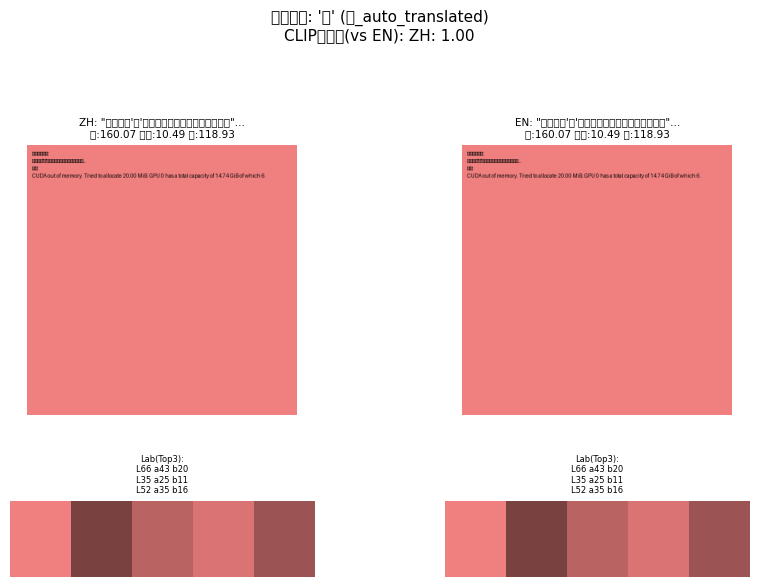

  概念 '酷_auto_translated' 分析完畢。


處理概念 #2: '柔軟' (柔軟_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '柔軟_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'柔軟'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'柔軟'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【柔軟】| 語言提示: 【ZH: 一張描繪'柔軟'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'柔軟'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'柔軟'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【柔軟】| 語言提示: 【EN: 一張描繪'柔軟'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 26580 (\N{CJK UNIFIED IDEOGRAPH-67D4}) mi

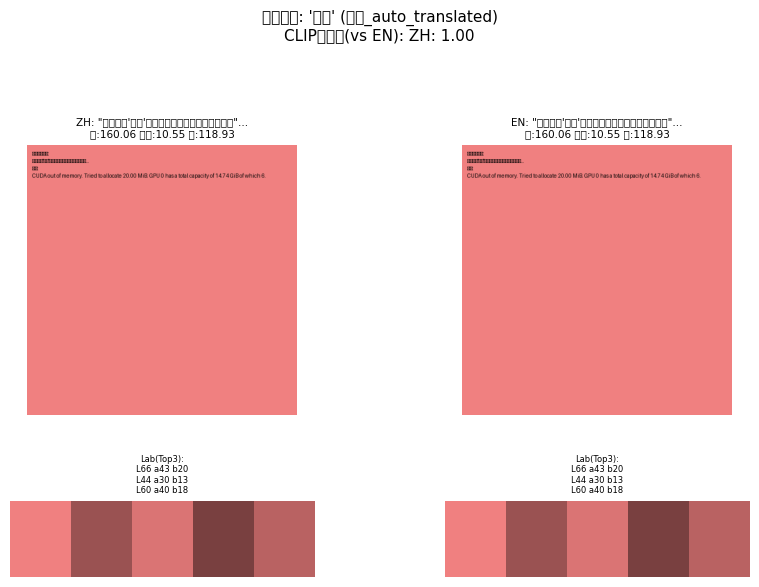

  概念 '柔軟_auto_translated' 分析完畢。


處理概念 #3: '明亮' (明亮_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '明亮_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'明亮'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'明亮'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【明亮】| 語言提示: 【ZH: 一張描繪'明亮'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'明亮'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'明亮'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【明亮】| 語言提示: 【EN: 一張描繪'明亮'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 26126 (\N{CJK UNIFIED IDEOGRAPH-660E}) mi

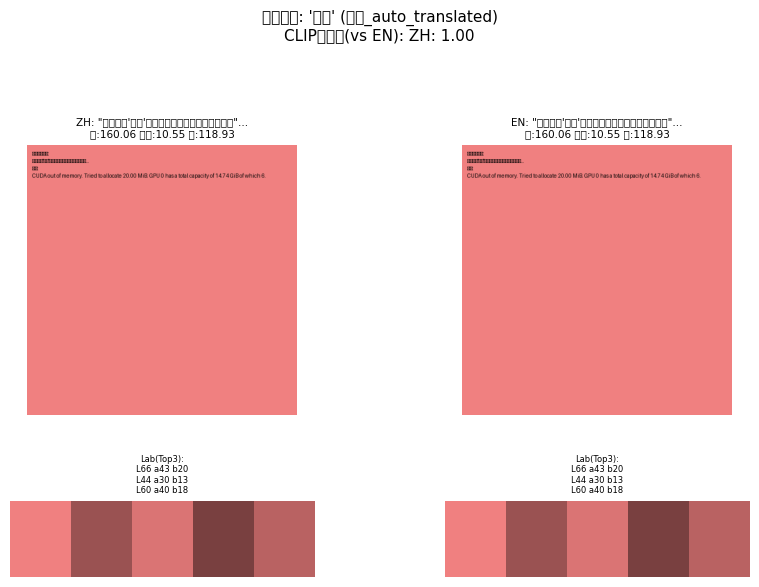

  概念 '明亮_auto_translated' 分析完畢。


處理概念 #4: '黑暗' (黑暗_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '黑暗_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'黑暗'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'黑暗'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【黑暗】| 語言提示: 【ZH: 一張描繪'黑暗'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'黑暗'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'黑暗'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【黑暗】| 語言提示: 【EN: 一張描繪'黑暗'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 40657 (\N{CJK UNIFIED IDEOGRAPH-9ED1}) mi

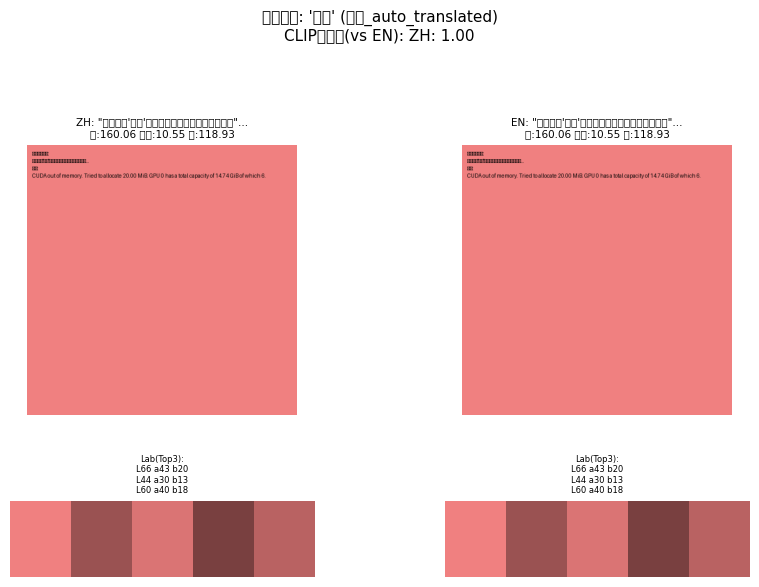

  概念 '黑暗_auto_translated' 分析完畢。


處理概念 #5: '純潔' (純潔_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '純潔_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'純潔'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'純潔'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【純潔】| 語言提示: 【ZH: 一張描繪'純潔'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'純潔'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'純潔'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【純潔】| 語言提示: 【EN: 一張描繪'純潔'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32020 (\N{CJK UNIFIED IDEOGRAPH-7D14}) mi

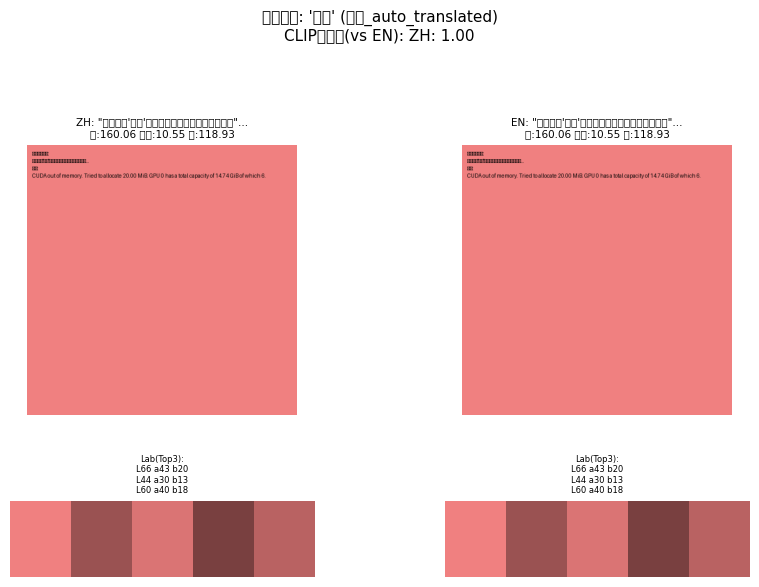

  概念 '純潔_auto_translated' 分析完畢。


處理概念 #6: '溫暖' (溫暖_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '溫暖_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'溫暖'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'溫暖'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【溫暖】| 語言提示: 【ZH: 一張描繪'溫暖'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'溫暖'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'溫暖'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【溫暖】| 語言提示: 【EN: 一張描繪'溫暖'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 28331 (\N{CJK UNIFIED IDEOGRAPH-6EAB}) mi

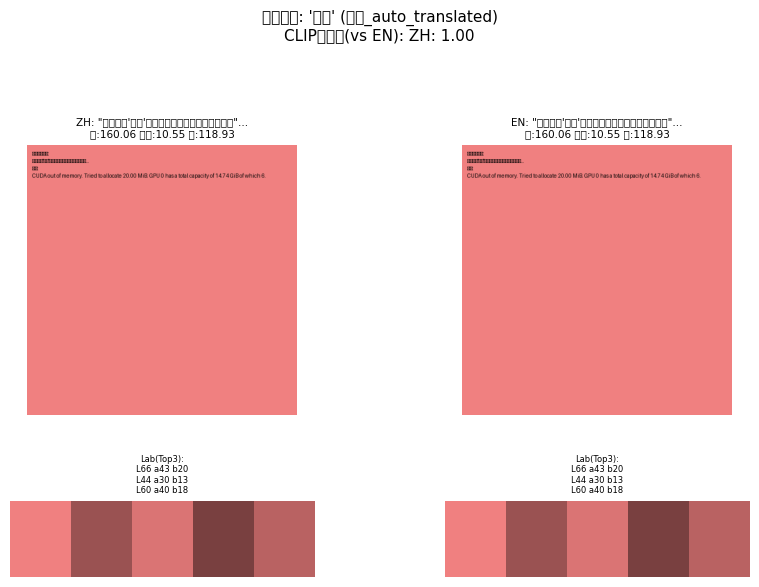

  概念 '溫暖_auto_translated' 分析完畢。


處理概念 #7: '快樂' (快樂_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '快樂_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'快樂'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'快樂'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【快樂】| 語言提示: 【ZH: 一張描繪'快樂'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'快樂'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'快樂'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【快樂】| 語言提示: 【EN: 一張描繪'快樂'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24555 (\N{CJK UNIFIED IDEOGRAPH-5FEB}) mi

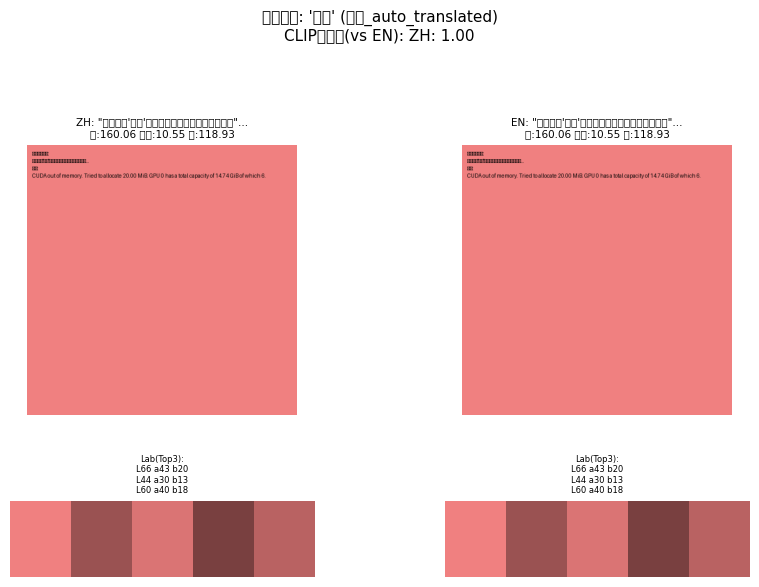

  概念 '快樂_auto_translated' 分析完畢。


處理概念 #8: '生氣' (生氣_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '生氣_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'生氣'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'生氣'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【生氣】| 語言提示: 【ZH: 一張描繪'生氣'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'生氣'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'生氣'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【生氣】| 語言提示: 【EN: 一張描繪'生氣'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) mi

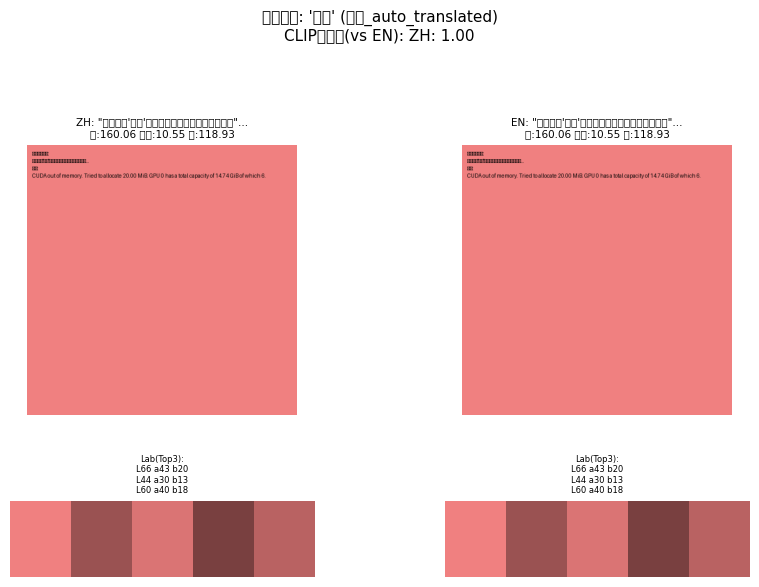

  概念 '生氣_auto_translated' 分析完畢。


處理概念 #9: '傷心' (傷心_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '傷心_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'傷心'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'傷心'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【傷心】| 語言提示: 【ZH: 一張描繪'傷心'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'傷心'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'傷心'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【傷心】| 語言提示: 【EN: 一張描繪'傷心'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 20663 (\N{CJK UNIFIED IDEOGRAPH-50B7}) mi

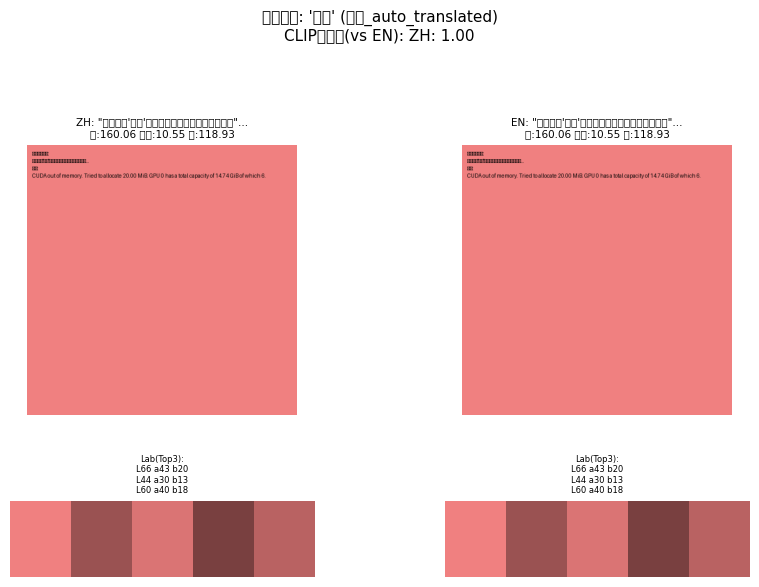

  概念 '傷心_auto_translated' 分析完畢。


處理概念 #10: '驚訝' (驚訝_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '驚訝_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'驚訝'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'驚訝'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【驚訝】| 語言提示: 【ZH: 一張描繪'驚訝'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'驚訝'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'驚訝'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【驚訝】| 語言提示: 【EN: 一張描繪'驚訝'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 39514 (\N{CJK UNIFIED IDEOGRAPH-9A5A}) mi

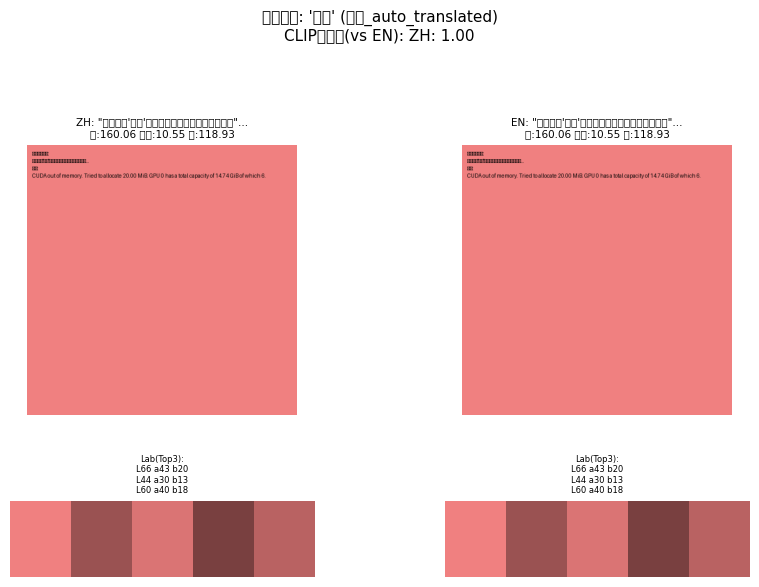

  概念 '驚訝_auto_translated' 分析完畢。


處理概念 #11: '餓' (餓_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '餓_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'餓'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'餓'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【餓】| 語言提示: 【ZH: 一張描繪'餓'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #7a4141, #ba6363 ...
全局圖像特徵: 亮度=160.07, 對比度=10.49, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'餓'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'餓'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【餓】| 語言提示: 【EN: 一張描繪'餓'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #7a4141, #ba6363 ...
全局圖像特徵: 亮度=160.07, 對比度=10.49, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 39187 (\N{CJK UNIFIED IDEOGRAPH-9913}) mi

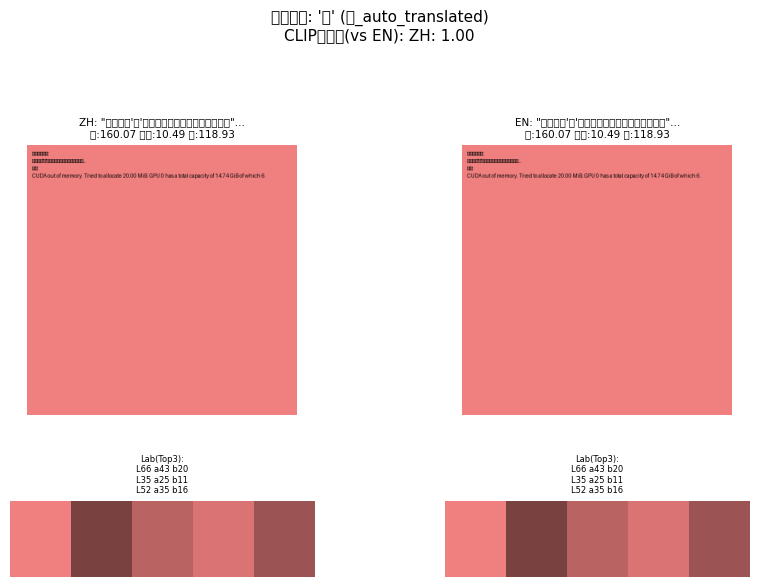

  概念 '餓_auto_translated' 分析完畢。


處理概念 #12: '疲憊' (疲憊_auto_translated)
  [1. CLIP嵌入分析]
  CLIP文本嵌入向量餘弦相似度 (vs 'EN'):
    - 與 ZH: 1.000
  [2. 圖像生成、顏色與全局特徵分析]


  '疲憊_auto_translated'語言處理:   0%|          | 0/2 [00:00<?, ?it/s]

    -> ZH: '一張描繪'疲憊'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'疲憊'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【疲憊】| 語言提示: 【ZH: 一張描繪'疲憊'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: '一張描繪'疲憊'的圖片，展現其典型特徵和氛圍'


  0%|          | 0/20 [00:00<?, ?it/s]

  生成圖像時出錯 ('一張描繪'疲憊'的圖片，展現其典型特徵和氛圍...'): CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 14267 has 14.73 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 50.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- 解釋模板 for 概念:【疲憊】| 語言提示: 【EN: 一張描繪'疲憊'的圖片，展現其典型特徵和氛圍...】 ---
圖像主要色票 (HEX): #f08080, #9a5252, #da7474 ...
全局圖像特徵: 亮度=160.06, 對比度=10.55, 飽和度=118.93

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------


  [3. 繪製結果圖表]


<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 24373 (\N{CJK UNIFIED IDEOGRAPH-5F35}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 25551 (\N{CJK UNIFIED IDEOGRAPH-63CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 32362 (\N{CJK UNIFIED IDEOGRAPH-7E6A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94]); plt.subplots_adjust(hspace=0.5, wspace=0.3); plt.show()
<ipython-input-37-31a4d00cce96>:65: UserWarning: Glyph 30130 (\N{CJK UNIFIED IDEOGRAPH-75B2}) mi

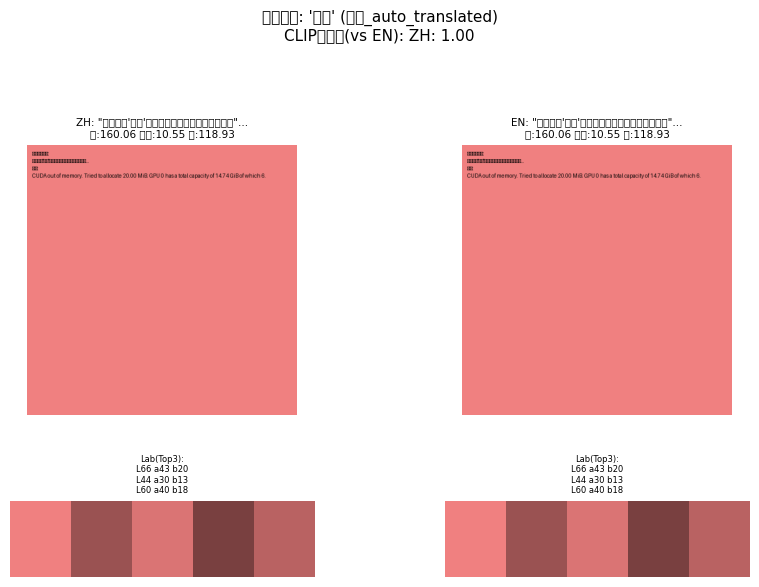

  概念 '疲憊_auto_translated' 分析完畢。


所有詞彙概念處理完成！解釋模板已在上方打印。
正在清理模型資源...
  模型和資源清理操作已執行。
腳本執行完畢。


In [ ]:
# 主執行流程
if __name__ == '__main__':
    # 1. 初始化配置管理器
    config_mgr = ConfigManager()

    # 2. 初始化模型管理器
    model_mgr = ModelManager(device=config_mgr.device, hf_device_id=config_mgr.hf_device_id)
    clip_model, _ = model_mgr.load_clip_model()
    sd_pipeline = model_mgr.load_sd_model()
    translation_pipelines = model_mgr.init_translation_models(target_languages=['en', 'ja', 'ko'])

    # 3. 初始化數據提供者，並清空預設概念
    concept_provider = ConceptDataProvider(clear_default_concepts=True)

    # 定義你想要自動翻譯和分析的中文詞彙列表
    chinese_terms_to_analyze = [
        "酷",
        "柔軟",
        "明亮",
        "黑暗",
        "純潔",
        "溫暖",
        "快樂",
        "生氣",
        "傷心",
        "驚訝",
        "餓",
        "疲憊"
    ]

    print(f"\n--- 開始為用戶定義的 {len(chinese_terms_to_analyze)} 個詞彙添加概念 ---")
    if not any(translation_pipelines.values()):
        print("警告：沒有可用的翻譯模型，將主要使用中文原文作為提示。")

    for term_index, term_input in enumerate(chinese_terms_to_analyze):
        core_chinese_word = ""
        chinese_description = None

        if isinstance(term_input, str):
            core_chinese_word = term_input
            chinese_description = f"一張描繪'{term_input}'的圖片，展現其典型特徵和氛圍"
        elif isinstance(term_input, tuple) and len(term_input) == 2:
            core_chinese_word = term_input[0]
            chinese_description = term_input[1]
        else:
            print(f"跳過無效的輸入格式: {term_input}")
            continue

        print(f"  處理輸入 #{term_index + 1}: 核心詞='{core_chinese_word}', 描述='{chinese_description}'")
        concept_provider.add_concept_with_auto_translation(
            translation_pipelines=translation_pipelines,
            base_chinese=core_chinese_word,
            chinese_description_for_prompt=chinese_description,
            target_languages=['en', 'ja', 'ko']
        )
    print("--- 用戶定義詞彙概念添加完成 ---")

    # 4. 初始化分析流程所需模組
    text_analyzer = TextAnalyzer(clip_model=clip_model, device=config_mgr.device)
    image_processor = ImageProcessor(sd_pipeline=sd_pipeline, device=config_mgr.device)
    report_generator = ReportGenerator()

    # 建立分析流程管線（修正這裡的變數名稱）
    analysis_pipeline = AnalysisPipeline(
        config_manager=config_mgr,
        model_manager=model_mgr,
        concept_provider=concept_provider,
        text_analyzer=text_analyzer,
        image_processor=image_processor,
        report_generator=report_generator
    )

    # 5. 執行分析流程
    if not concept_provider.get_concepts_to_process():
        print("沒有任何概念被定義，無法執行分析流程。請檢查 `chinese_terms_to_analyze`。")
    else:
        all_results = analysis_pipeline.run_analysis()
        # 這裡可以根據需要輸出或儲存 all_results

    # 6. 清理資源
    model_mgr.cleanup()

    print("腳本執行完畢。")
